## Imports

In [1]:
%pylab inline
import pandas as pd 
import requests
from bs4 import BeautifulSoup
import pickle
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
#https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html
from statsmodels.tsa.arima_model import ARIMA

## Data loading & cleaning

In [3]:
from helper import clean_data

In [4]:
vix_close , prime, weekly_vix = clean_data()

In [5]:
weekly_vix.shape

(1516, 1)

## Look for stationarity of my data with Dicker Fuller test

In [6]:
import statsmodels.tsa.stattools as ts
from helper import dftest

Test Statistic            -5.508621
p-value                    0.000002
Lags Used                 11.000000
Observations Used       7305.000000
Critical Value (1%)       -3.431245
Critical Value (5%)       -2.861936
Critical Value (10%)      -2.566981
dtype: float64


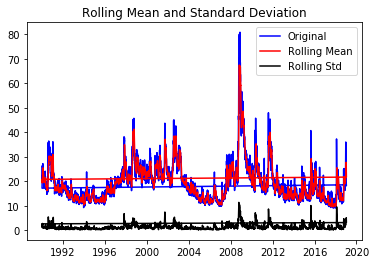

In [7]:
dftest(vix_close.vix_close)

It passed! According to Jonathan I can still try differencing.

## Let's split data up into test and train - SKIPPED

In [8]:
from helper import split_data

In [9]:
train, validation, test = split_data(weekly_vix)

## Now let's try an AR models

First let's optimize p. I stopped at 15 because it got too slow.

In [11]:
from helper import optimize_ar
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

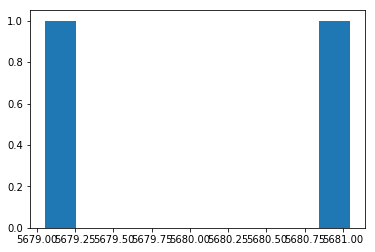

In [12]:
train_ar_params = optimize_ar(train, 3)

Best AIC for AR is 26804.84334590905 at p=12

In [13]:
train_ar_params

(5679.055033817317, 1)

14 says it is the best, but the histogram shows only 20 points decrease from worst, so let's use a simple model which optimizes at p=1.

In [ ]:
train_ar_params = optimize_ar(train, 3)

In [ ]:
train_ar_params

## Now let's try an AR models with differencing (ARI?)

In [ ]:
model = ARIMA(train, order=(1,1,0))
model_fit = model.fit()
model_fit.aic

Model is worse with d at 1 or 2!

## Now let's try an ARIMA model

In [ ]:
#I'm making p smaller to decrease compute time
aic_res_arima = []
for i in range(1,10):
    model = ARIMA(train, order=(1,0,i))
    model_fit = model.fit()
    #print(i, model_fit.aic)
    aic_res_arima.append(model_fit.aic)

In [ ]:
np.array(aic_res_arima).argmin()

In [ ]:
aic_res_arima

MA also don't help, keep Q=0

Seems like my best model is (p,d,q) = (1,0,0) so far with an AIC of 5679.

## Let's try predicting things

In [ ]:
best_model_so_far = ARIMA(train, order=(5,0,0))
best_model_so_far = model.fit()

In [ ]:
best_model_so_far.aic

In [ ]:
validation.head()

In [ ]:
validation['preds'] = best_model_so_far.predict(weekly_vix.shape[0]-52*4, weekly_vix.shape[0]-52*2, dynamic=False)

In [ ]:
validation.head()

In [ ]:
validation[['vix_close','preds']].plot()
#validation.plot('vix_close','preds')

In [ ]:
old_working_model = ARIMA(weekly_vix,order=(1,0,0))
old_working_model = old_working_model.fit()
old_working_model.aic

In [ ]:
weekly_vix.shape

In [ ]:
weekly_vix['preds'] = old_working_model.predict(start = 300, end= 500, dynamic=False)
weekly_vix[['vix_close','preds']].plot();

## SARIMA test

In [ ]:
import statsmodels.api as sm

In [ ]:
sar = sm.tsa.statespace.SARIMAX(vix_close, order=(5,2,0), seasonal_order=(0,0,0,12), trend='c').fit()
sar.aic

SARIMA isn't doing as well on AIC at 28397.04464448893

In [ ]:
monthly_vix = vix_close.resample('M').mean() #monthly data does way better for AIC, but does it generalize?

In [ ]:
# we might need to install dev version for statespace functionality
#!pip install git+https://github.com/statsmodels/statsmodels.git
import statsmodels.api as sm

# fit SARIMA monthly based on helper plots
sar = sm.tsa.statespace.SARIMAX(monthly_vix.vix_close, order=(5,2,0), seasonal_order=(5,1,0,12), trend='c').fit()
sar.summary()

## Decent model, let's get predictions and MMSE

In [ ]:
pred = sar.get_prediction(300,320)

In [ ]:
ax = monthly_vix.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('VIX price')
plt.legend()

plt.show()
pred.predicted_mean.plot

In [ ]:
sar = sm.tsa.statespace.SARIMAX(vix_closex.vix_close, order=(5,2,0), seasonal_order=(5,1,0,12), trend='c').fit()
sar.summary()

## Get predictions

In [ ]:
#either monthly vix or test
pred = sar.get_prediction(test.vix_close, dynamic=False)
